In [1]:
import os,sys
sys.path.append('../src/python/')

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing._encoders import _BaseEncoder

from skl2onnx.sklapi import CastTransformer
from models.onnxlib import ONNXConverter, ONNXPredictorCLF, ONNXPredictorREGR

# Loading the dataset:

## Data Set Information:

Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).


Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The number of rings is the value to predict: either as a continuous value or as a classification problem.

## Name / Data Type / Measurement Unit / Description
-----------------------------
- Sex / nominal / -- / M, F, and I (infant)
- Length / continuous / mm / Longest shell measurement
- Diameter / continuous / mm / perpendicular to length
- Height / continuous / mm / with meat in shell
- Whole weight / continuous / grams / whole abalone
- Shucked weight / continuous / grams / weight of meat
- Viscera weight / continuous / grams / gut weight (after bleeding)
- Shell weight / continuous / grams / after being dried
- Rings / integer / -- / +1.5 gives the age in years

In [2]:
data = pd.read_csv('../data/raw/abalone.csv')
data.columns = [x.replace(' ', '_').lower() for x in data.columns]
data

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [3]:
data['sex'].value_counts(dropna=False)

M    1528
I    1342
F    1307
Name: sex, dtype: int64

In [4]:
data.columns

Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
whole_weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
shucked_weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880
viscera_weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600
shell_weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000


# Data preparation:

In [7]:
TARGET_COL = 'rings'

In [8]:
X = data.drop(columns=[TARGET_COL])
y = data[TARGET_COL]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
print('Train:', x_train.shape[0], 'samples', x_train.shape[1], 'columns')
print('Test:', x_test.shape[0], 'samples', x_test.shape[1], 'columns')

Train: 2923 samples 8 columns
Test: 1254 samples 8 columns


# Pre-processing Pipeline:

In [11]:
# Creating the transformation:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', dtype=np.float32))])

In [12]:
# Feature Encoding:

# numeric_features = []
numeric_features = ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']

# categorical_features  = []
categorical_features  = ['sex']

passthrough_features = []
all_features_ = (numeric_features + categorical_features
                 + passthrough_features)

features_encoder = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_transformer, categorical_features),
#                                                    ('passthrough', 'passthrough', passthrough_features),
                                                  ],
                                     remainder='drop')

In [13]:
# Feature Construction:
features_creator = PolynomialFeatures(2, include_bias=False)

In [14]:
# Feature Selection:
regr_select = LinearRegression()
features_selector = SelectFromModel(regr_select)

In [15]:
preprocessor = Pipeline([('feature_encoding', features_encoder),
#                          ('feature_creation', features_creator),
#                          ('feature_selection', features_selector),
                        ])

In [16]:
# Columns dropped by preprocessor:
columns_to_drop = data.columns[~np.isin(data.columns, all_features_)]
columns_to_drop

Index(['rings'], dtype='object')

In [17]:
x_train_encoded = preprocessor.fit_transform(x_train, y_train)
pd.DataFrame(x_train_encoded)

,0,1,2,3,4,5,6,7,8,9
0,0.608108,0.630252,0.119469,0.298034,0.290182,0.236340,0.179372,1.0,0.0,0.0
1,0.479730,0.453782,0.088496,0.128387,0.105245,0.107966,0.103139,0.0,1.0,0.0
2,0.513514,0.495798,0.092920,0.146627,0.108608,0.127057,0.143000,0.0,0.0,1.0
3,0.175676,0.168067,0.039823,0.014344,0.010760,0.006583,0.013951,0.0,0.0,1.0
4,0.695946,0.689076,0.141593,0.389056,0.339610,0.331797,0.292476,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2918,0.560811,0.579832,0.101770,0.200815,0.171486,0.173799,0.143000,1.0,0.0,0.0
2919,0.804054,0.831933,0.168142,0.491766,0.364156,0.398947,0.397110,1.0,0.0,0.0
2920,0.587838,0.571429,0.110619,0.204888,0.163416,0.175115,0.185850,0.0,0.0,1.0
2921,0.675676,0.689076,0.106195,0.372410,0.346335,0.287031,0.232686,0.0,0.0,1.0


In [18]:
x_test_encoded = pd.DataFrame(preprocessor.transform(x_test))
x_test_encoded

,0,1,2,3,4,5,6,7,8,9
0,0.716216,0.672269,0.141593,0.390119,0.282448,0.396313,0.322372,0.0,0.0,1.0
1,0.695946,0.647059,0.132743,0.308305,0.259583,0.282423,0.242651,0.0,0.0,1.0
2,0.655405,0.655462,0.172566,0.346733,0.204438,0.294931,0.332337,1.0,0.0,0.0
3,0.756757,0.731092,0.150442,0.446078,0.361466,0.350230,0.377180,1.0,0.0,0.0
4,0.540541,0.554622,0.128319,0.217992,0.157364,0.141540,0.212755,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1249,0.722973,0.722689,0.154867,0.440057,0.365165,0.390388,0.342302,0.0,0.0,1.0
1250,0.290541,0.285714,0.066372,0.048876,0.033961,0.030283,0.038366,1.0,0.0,0.0
1251,0.608108,0.596639,0.101770,0.273597,0.279085,0.213957,0.177877,1.0,0.0,0.0
1252,0.817568,0.781513,0.163717,0.528422,0.412912,0.517446,0.403089,1.0,0.0,0.0


# Training the model into the main pipeline:

In [19]:
# # Training the model and getting the results:
# lr_regr = LinearRegression()
# estimator = lr_regr.fit(x_train_encoded, y_train)

# model_full = Pipeline(steps=[('preprocessor', preprocessor),
#                              ('estimator', lr_regr)])

# # Com o linear regressor e OneHotEncoder houve problema na predição do ONNX
# # Aparentemente os coeficientes ligados ao OneHot ficavam com valores inadequados.

In [20]:
# Training the model and getting the results:
rf_regr = RandomForestRegressor()
estimator = rf_regr.fit(x_train_encoded, y_train)

model_full = Pipeline(steps=[('preprocessor', preprocessor),
                             ('estimator', estimator)])

In [21]:
y_train_pred = model_full.predict(x_train)
y_test_pred = model_full.predict(x_test)

# Model evaluation:

In [22]:
print(f'MAE (train): {mean_absolute_error(y_train, y_train_pred)} MAE (test): {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE (train): {mean_squared_error(y_train, y_train_pred)} MSE (test): {mean_squared_error(y_test, y_test_pred)}')
print(f'R2 score (train): {r2_score(y_train, y_train_pred)} R2 score (test): {r2_score(y_test, y_test_pred)}')

MAE (train): 0.5722716387273349 MAE (test): 1.551682615629984
MSE (train): 0.6689935340403695 MSE (test): 4.837446650717704
R2 score (train): 0.9362047332390514 R2 score (test): 0.5236181691190818


# Converting to ONNX format

In [23]:
onnx_conv = ONNXConverter(preprocessor, estimator)

In [24]:
onnx_conv.convert_initial_types(x_train, y_train, columns_to_drop, show_types=True)


Initial types preprocessing (8):
sex StringTensorType(shape=[None, 1])
length FloatTensorType(shape=[None, 1])
diameter FloatTensorType(shape=[None, 1])
height FloatTensorType(shape=[None, 1])
whole_weight FloatTensorType(shape=[None, 1])
shucked_weight FloatTensorType(shape=[None, 1])
viscera_weight FloatTensorType(shape=[None, 1])
shell_weight FloatTensorType(shape=[None, 1])

Initial types estimator (1):
x_values FloatTensorType(shape=[None, 10])


In [25]:
prep_filename = '../models/sklearn_preprocessor_v0.onnx'
estimator_filename = '../models/sklearn_model_v0.onnx'

onnx_conv.dump_models(prep_filename=prep_filename,estimator_filename=estimator_filename)

../models/sklearn_preprocessor_v0.onnx saved successfully.
../models/sklearn_model_v0.onnx saved successfully.


# Loading the ONNX files and performing predictions:

In [26]:
onnx_pred = ONNXPredictorREGR(prep_filename, estimator_filename)
onnx_pred.run_predictions(x_test)

array([12.83    ,  9.380001, 14.589999, ...,  8.730001, 11.590001,
       10.26    ], dtype=float32)

In [27]:
value_diffs = y_test_pred - onnx_pred.output_value
value_diffs

array([ 7.62939454e-08,  9.99893188e-03,  2.00008011e-02, ...,
       -1.44958496e-06,  1.69998894e-01, -2.28881836e-07])

In [28]:
y_test_onnx = np.round(onnx_pred.output_value, 4).astype(np.float32)
y_test_onnx

array([12.83,  9.38, 14.59, ...,  8.73, 11.59, 10.26], dtype=float32)

In [29]:
y_test_pred = np.round(y_test_pred, 4).astype(np.float32)
y_test_pred

array([12.83,  9.39, 14.61, ...,  8.73, 11.76, 10.26], dtype=float32)

In [30]:
print(sum(y_test_pred == y_test_onnx), 'equal results')
print(sum(y_test_pred != y_test_onnx), 'different results')

665 equal results
589 different results


In [31]:
abs(value_diffs).mean()

0.017935017269383957

In [32]:
abs(value_diffs).max()

0.3499997329711917

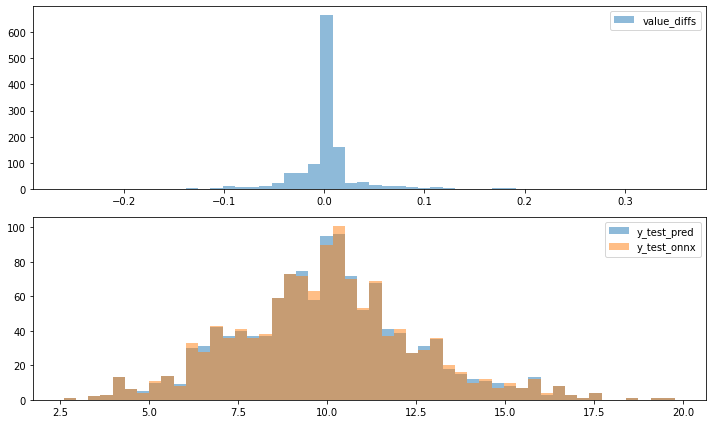

In [33]:
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.hist(value_diffs, bins=50, alpha=0.5, label='value_diffs')
plt.legend()
plt.subplot(2,1,2)
plt.hist(y_test_pred, bins=50, alpha=0.5, label='y_test_pred')
plt.hist(y_test_onnx, bins=50, alpha=0.5, label='y_test_onnx')
plt.legend()

plt.tight_layout()
plt.show()

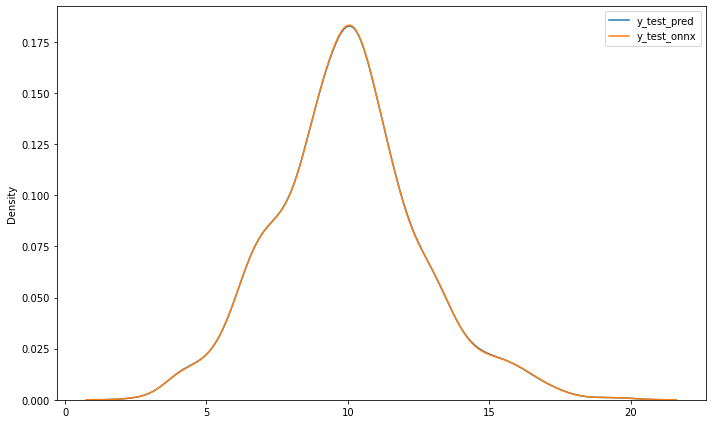

In [34]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=y_test_pred, alpha=0.5, label='y_test_pred')
sns.kdeplot(data=y_test_onnx, alpha=0.5, label='y_test_onnx')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Analyzing x values:
x_test_encoded.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.716216,0.672269,0.141593,0.390119,0.282448,0.396313,0.322372,0.0,0.0,1.0
1,0.695946,0.647059,0.132743,0.308305,0.259583,0.282423,0.242651,0.0,0.0,1.0
2,0.655405,0.655462,0.172566,0.346733,0.204438,0.294931,0.332337,1.0,0.0,0.0
3,0.756757,0.731092,0.150442,0.446078,0.361466,0.350230,0.377180,1.0,0.0,0.0
4,0.540541,0.554622,0.128319,0.217992,0.157364,0.141540,0.212755,0.0,0.0,1.0
5,0.601351,0.546218,0.123894,0.185231,0.118695,0.150757,0.182860,0.0,1.0,0.0
6,0.601351,0.563025,0.115044,0.195679,0.157700,0.143515,0.187344,0.0,1.0,0.0
7,0.547297,0.537815,0.101770,0.238888,0.214862,0.139566,0.167912,0.0,0.0,1.0
8,0.391892,0.378151,0.079646,0.068709,0.057498,0.046741,0.058794,0.0,1.0,0.0
9,0.689189,0.689076,0.128319,0.348327,0.290182,0.281764,0.282013,1.0,0.0,0.0


In [36]:
x_test_encoded_onnx = pd.DataFrame(onnx_pred.enconded_x)
x_test_encoded_onnx.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.716216,0.672269,0.141593,0.390119,0.282448,0.396313,0.322372,0.0,0.0,1.0
1,0.695946,0.647059,0.132743,0.308305,0.259583,0.282423,0.242651,0.0,0.0,1.0
2,0.655405,0.655462,0.172566,0.346733,0.204438,0.294931,0.332337,1.0,0.0,0.0
3,0.756757,0.731092,0.150442,0.446078,0.361466,0.350230,0.377180,1.0,0.0,0.0
4,0.540541,0.554622,0.128319,0.217992,0.157364,0.141540,0.212755,0.0,0.0,1.0
5,0.601351,0.546218,0.123894,0.185231,0.118695,0.150757,0.182860,0.0,1.0,0.0
6,0.601351,0.563025,0.115044,0.195679,0.157700,0.143515,0.187344,0.0,1.0,0.0
7,0.547297,0.537815,0.101770,0.238888,0.214862,0.139565,0.167912,0.0,0.0,1.0
8,0.391892,0.378151,0.079646,0.068709,0.057498,0.046741,0.058794,0.0,1.0,0.0
9,0.689189,0.689076,0.128319,0.348327,0.290182,0.281764,0.282013,1.0,0.0,0.0


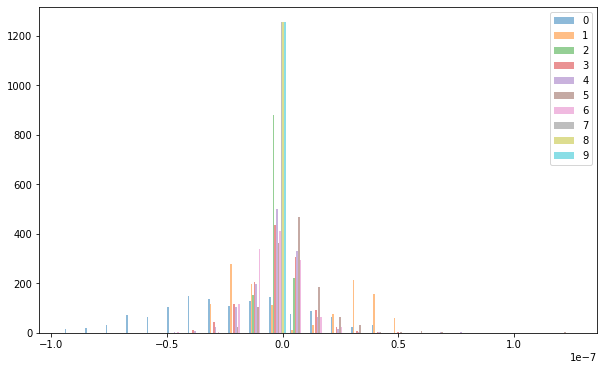

In [37]:
xvalues_diff = x_test_encoded - onnx_pred.enconded_x

plt.figure(figsize=(10, 6))
plt.hist(xvalues_diff, bins=25, alpha=0.5, label=xvalues_diff.columns)
plt.legend()
plt.show()

In [38]:
# # Deleting all files created:
# os.remove(onnx_pred.prep_filename)
# os.remove(onnx_pred.estimator_filename)